In [30]:
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np
from matplotlib import pyplot as plt

In [6]:
def read_fen(fen: str):
    board = []
    for char in fen:
        if(char.isdigit()):
            board += [np.nan] * int(char)
        elif(char != '-'):
            board += char
    board = np.reshape(board, (8, 8))
    return board

In [7]:
def load_data(path: Path):
    X = []
    y = []
    for x in path.glob("*.npy"):
        X.append(np.load(x))
        y.append(read_fen(x.stem))

    X = np.array(X)
    X = np.moveaxis(X, 0, -1)
    X = X.T.reshape(
        (
            X.shape[-1] * 8 * 8,  # number of squares
            50 * 50,  # pixels per square
        )
    )

    y = np.array(y).flatten()

    return X, y

In [ ]:
path = Path('../../data/processed')
# LOAD DATA
tr_X, tr_y = load_data(path.joinpath('train'))
scaler = StandardScaler()
pca = PCA()

pipeline = Pipeline([
    ("scaler", scaler),
    ("pca", pca),
    ("model", SVC(max_iter=10000))  
])

param_grid = {
    "pca__n_components": [10, 30, 60],
    'model__C' : [.0001, .01, 1, 10, 100],
    'model__kernel' : ['linear', 'rbf', 'sigmoid'],
}

gridsearch = GridSearchCV(pipeline, param_grid, n_jobs=1, verbose=10, cv=3)

gridsearch.fit(tr_X, tr_y)

test_X, test_y = load_data(path.joinpath('test'))
score = gridsearch.best_score_
print(score)

In [23]:
np.unique(gridsearch.predict(test_X))

array(['nan'], dtype='<U32')

In [15]:
gridsearch.best_params_

{'model__C': 0.0001, 'model__kernel': 'linear'}

In [24]:
gridsearch.score(test_X, test_y)

0.83209375

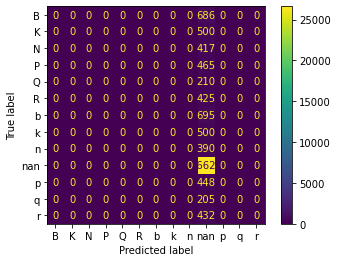

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, test_X, test_y)
plt.savefig("./{MODEL_NAME}.png")